<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 758 (delta 1), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (758/758), 117.08 MiB | 33.21 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16678 sha256=3332e1f89652b4ac953f1cf08e05197311da2d61a58b551db733f9f2d163559a
  Stored in directory: /tmp/pip-ephem-wheel-cache-r6aa2rh2/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul
  Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [2]:
# %tensorflow_version 1.x
from deepul.hw4_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

In [3]:
from typing import NoReturn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
import torch.utils.data as data

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [5]:
class Base(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError
    
    def mode(self, mode_type: str) -> NoReturn:
        requires_grad = mode_type == 'train'
        for param in self.parameters():
            param.requires_grad = requires_grad

In [6]:
class GANBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = None
        self.discriminator = None

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    def generator_loss(self, minibatch_size: int) -> torch.Tensor:
        raise NotImplementedError
    
    def discriminator_loss(self, minibatch: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

In [7]:
def discriminator_step(model, opt, minibatch, mode_type='train'):
    model.generator.eval()
    model.generator.mode('eval')

    if mode_type == 'train':
        model.discriminator.train()
    else:
        model.discriminator.eval()
    model.discriminator.mode(mode_type)

    minibatch = minibatch.to(device).float()

    loss = model.discriminator_loss(minibatch)
    if mode_type == 'train':
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item()


def generator_step(model, opt, minibatch_size, mode_type='train'):
    model.discriminator.eval()
    model.discriminator.mode('eval')

    if mode_type == 'train':
        model.generator.train()
    else:
        model.generator.eval()
    model.generator.mode(mode_type)

    loss = model.generator_loss(minibatch_size)
    if mode_type == 'train':
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item()

def additional(model, N=5000, num_linspace=1000):
    model.generator.eval()
    model.generator.mode('eval')

    model.discriminator.eval()
    model.discriminator.mode('eval')
    
    generated = model.generate(N).cpu().numpy().reshape((-1, ))

    lin = torch.linspace(-1, 1, num_linspace).to(device)
    rating = model.discriminator(lin.view(-1, 1)).cpu().numpy().reshape((-1, ))
    return generated, lin.cpu().numpy(), rating


def train(model, opt_generator, opt_discriminator, dataloader,
          num_epochs, update_generator_every, N=5000, num_linspace=1000, 
          need_additional=True, generator_scheduler=None, discriminator_scheduler=None):
    discriminator_losses = []
    generator_losses = []
    all_additional = []
    for epoch in range(num_epochs):
        if epoch == 1 and need_additional:
            all_additional.append(additional(model, N, num_linspace))

        for i, minibatch in enumerate(dataloader):
            discriminator_losses.append(
                discriminator_step(model, opt_discriminator, minibatch, 'train'))
            if i % update_generator_every:
                continue
            generator_losses.append(
                generator_step(model, opt_generator, len(minibatch), 'train'))

            if generator_scheduler is not None:
                generator_scheduler.step()
            if discriminator_scheduler is not None:
               discriminator_scheduler.step()
            
        print(f'Epoch: {epoch}, ' + 
              f'Discriminator loss: {np.mean(discriminator_losses[-len(dataloader) + 1:])}, ' + 
              f'Generator loss: {np.mean(generator_losses[-len(dataloader) + 1:])}')
    if need_additional:
        all_additional.append(additional(model, N, num_linspace))
    return np.array(discriminator_losses), np.array(generator_losses), all_additional

# Question 1: Warmup [20pt]

In this question, we will train 2 different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

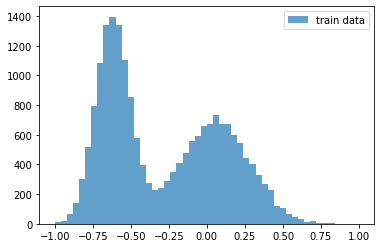

In [8]:
visualize_q1_dataset()

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 



In [7]:
class DummyNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(in_dim, hidden_dim), 
                                    nn.LeakyReLU(0.2), 
                                    nn.Linear(hidden_dim, hidden_dim), 
                                    nn.LeakyReLU(0.2), 
                                    nn.Linear(hidden_dim, out_dim))

    def forward(self, x):
        return self.layers(x)

In [8]:
class Discriminator(Base):
    def __init__(self, data_dim, hidden_dim):
        super().__init__()
        self.model = DummyNet(data_dim, hidden_dim, 1)
        self.last = nn.Sigmoid()

    def forward(self, x):
        return self.last(self.model(x))

In [9]:
class Generator(Base):
    def __init__(self, latent_dim, hidden_dim, data_dim):
        super().__init__()
        self.model = DummyNet(latent_dim, hidden_dim, data_dim)
        self.last = nn.Tanh()

    def forward(self, x):
        return self.last(self.model(x)) 

In [19]:
class GAN(GANBase):
    def __init__(self, data_dim, hidden_dim, latent_dim):
        super().__init__()
        self.data_dim = data_dim
        self.latent_dim = latent_dim

        self.noise = Normal(loc=torch.Tensor([0.]).to(device), 
                            scale=torch.Tensor([1.0]).to(device))
        self.generator = Generator(latent_dim=latent_dim, 
                                   hidden_dim=hidden_dim, 
                                   data_dim=data_dim)
        self.discriminator = Discriminator(data_dim=data_dim, 
                                           hidden_dim=hidden_dim)
    def generate(self, N):
        noise = self.noise.sample(sample_shape=(N, self.latent_dim))
        return self.generator(noise)
    
    def generator_loss(self, minibatch_size):
        z = self.generate(minibatch_size)
        return torch.log(1 - self.discriminator(z)).mean(axis=0)
    
    def discriminator_loss(self, minibatch):
        loss = self.generator_loss(len(minibatch))
        loss += torch.log(self.discriminator(minibatch)).mean(axis=0)
        return -loss # want to maximize

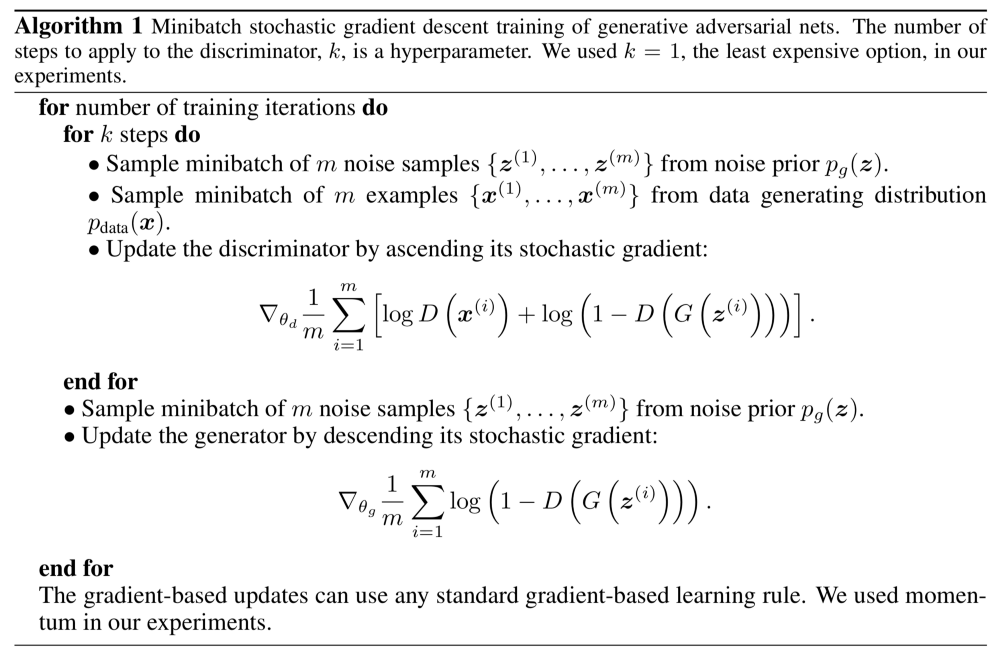

### Solution

In [117]:
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """
    dataloader = data.DataLoader(train_data, batch_size=256, shuffle=True)
    model = GAN(data_dim=1, hidden_dim=128, latent_dim=1).to(device)
    opt_generator = torch.optim.Adam(model.generator.parameters(), 
                                    lr=1e-4, betas=(0.1, 0.99))
    opt_discriminator = torch.optim.Adam(model.discriminator.parameters(), 
                                    lr=1e-4, betas=(0.1, 0.99))

    discriminator_losses, generator_losses, all_additional = train(
        model, opt_generator, opt_discriminator, dataloader, 
        update_generator_every=2, num_epochs=30)
    return (discriminator_losses, *all_additional[0], *all_additional[1])

### Results

Epoch: 0, Discriminator loss: 1.3650488150425446, Generator loss: -0.6870684593915939
Epoch: 1, Discriminator loss: 1.3916777005562415, Generator loss: -0.6909800683840727
Epoch: 2, Discriminator loss: 1.3794048459101946, Generator loss: -0.6907949707446954
Epoch: 3, Discriminator loss: 1.3830920457839966, Generator loss: -0.6907776938034937
Epoch: 4, Discriminator loss: 1.3838337507003393, Generator loss: -0.6928192644547193
Epoch: 5, Discriminator loss: 1.3859223570579138, Generator loss: -0.69208857187858
Epoch: 6, Discriminator loss: 1.385783281081762, Generator loss: -0.6922093553420825
Epoch: 7, Discriminator loss: 1.3861609192994924, Generator loss: -0.6925636216616019
Epoch: 8, Discriminator loss: 1.3860858632968023, Generator loss: -0.6930190103176312
Epoch: 9, Discriminator loss: 1.3860652538446279, Generator loss: -0.6930630818391458
Epoch: 10, Discriminator loss: 1.3860646944779615, Generator loss: -0.6928693973101102
Epoch: 11, Discriminator loss: 1.386134963769179, Genera

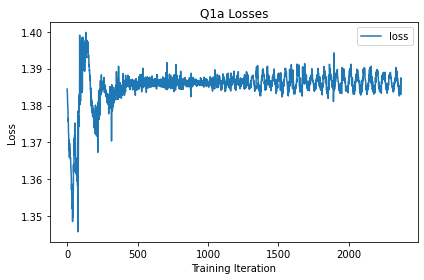

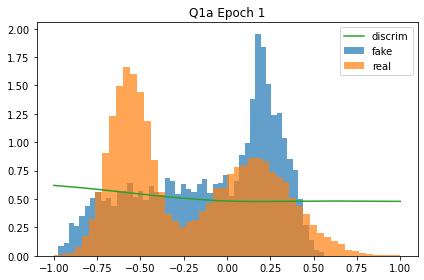

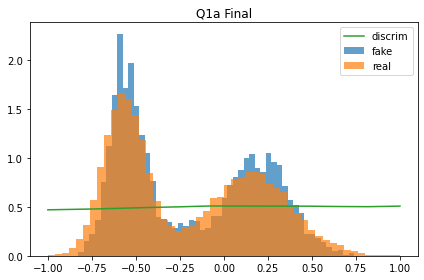

In [119]:
q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate losses:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$

 ### Solution

In [21]:
class GAN(GANBase):
    def __init__(self, data_dim, hidden_dim, latent_dim):
        super().__init__()
        self.data_dim = data_dim
        self.latent_dim = latent_dim

        self.noise = Normal(loc=torch.Tensor([0.]).to(device), 
                            scale=torch.Tensor([1.0]).to(device))
        self.generator = Generator(latent_dim=latent_dim, 
                                   hidden_dim=hidden_dim, 
                                   data_dim=data_dim)
        self.discriminator = Discriminator(data_dim=data_dim, 
                                           hidden_dim=hidden_dim)
    def generate(self, N):
        noise = self.noise.sample(sample_shape=(N, self.latent_dim))
        return self.generator(noise)
    
    def generator_loss(self, minibatch_size):
        z = self.generate(minibatch_size)
        return -torch.log(self.discriminator(z)).mean(axis=0)
    
    def discriminator_loss(self, minibatch):
        z = self.generate(len(minibatch))
        loss = torch.log(1 - self.discriminator(z)).mean(axis=0)
        loss += torch.log(self.discriminator(minibatch)).mean(axis=0)
        return -loss # want to maximize

In [33]:
def q1_b(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """
  
    dataloader = data.DataLoader(train_data, batch_size=256, shuffle=True)
    model = GAN(data_dim=1, hidden_dim=128, latent_dim=1).to(device)
    opt_generator = torch.optim.Adam(model.generator.parameters(), 
                                    lr=1e-4, betas=(0.05, 0.95))
    opt_discriminator = torch.optim.Adam(model.discriminator.parameters(), 
                                    lr=1e-4, betas=(0.05, 0.95))

    discriminator_losses, generator_losses, all_additional = train(
        model, opt_generator, opt_discriminator, dataloader, 
        update_generator_every=2, num_epochs=30)
    return (discriminator_losses, *all_additional[0], *all_additional[1])

 ### Results

Epoch: 0, Discriminator loss: 1.3750097155570984, Generator loss: 0.7029304146766663
Epoch: 1, Discriminator loss: 1.3845778122926369, Generator loss: 0.6984600249009255
Epoch: 2, Discriminator loss: 1.3838573633096156, Generator loss: 0.695337726519658
Epoch: 3, Discriminator loss: 1.3857258481857104, Generator loss: 0.6940869780687186
Epoch: 4, Discriminator loss: 1.385958078580025, Generator loss: 0.6937091312347314
Epoch: 5, Discriminator loss: 1.3859937129876552, Generator loss: 0.6935981015364329
Epoch: 6, Discriminator loss: 1.3860600025225909, Generator loss: 0.6934825854423718
Epoch: 7, Discriminator loss: 1.3862689244441497, Generator loss: 0.6934152788076645
Epoch: 8, Discriminator loss: 1.3861944262798016, Generator loss: 0.6934600831606449
Epoch: 9, Discriminator loss: 1.386333236327538, Generator loss: 0.6933781535197527
Epoch: 10, Discriminator loss: 1.3861848253470201, Generator loss: 0.693367579808602
Epoch: 11, Discriminator loss: 1.3863719931015601, Generator loss: 0

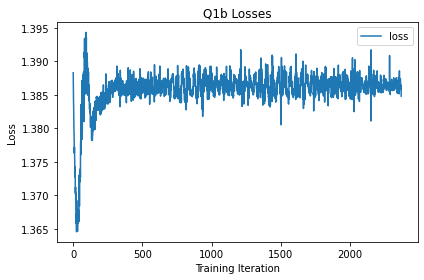

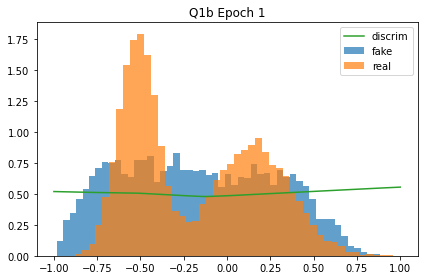

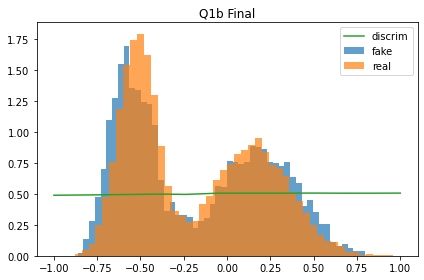

In [34]:
q1_save_results('b', q1_b)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

Files already downloaded and verified


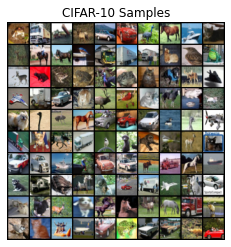

In [9]:
visualize_q2_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples. 

## Solution

In [10]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size
 
    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output
 
 
class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size
 
    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output


```
# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
 
 
# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

In [11]:
# Spatial Upsampling with Nearest Neighbors
class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), 
                 stride=1, padding=1, bias=True):
        super().__init__()
        self.DtS = DepthToSpace(block_size=2)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
    
    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        return self.conv(self.DtS(x))
        
 
 
# Spatial Downsampling with Spatial Mean Pooling
class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), 
                 stride=1, padding=1, bias=True):
        super().__init__()
        self.StD = SpaceToDepth(2)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, 
                              stride=stride, padding=padding, bias=bias)
    def forward(self, x):
        x = self.StD(x)
        x = sum(x.chunk(4, dim=1)) / 4.0
        return self.conv(x)

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```

In [12]:
class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.res = nn.Sequential(nn.BatchNorm2d(in_dim), 
                                 nn.ReLU(), 
                                 nn.Conv2d(in_dim, n_filters, 
                                           kernel_size, padding=1), 
                                 nn.BatchNorm2d(n_filters), 
                                 nn.ReLU(), 
                                 Upsample_Conv2d(n_filters, n_filters, 
                                                 kernel_size, padding=1))
        self.shortcut = Upsample_Conv2d(in_dim, n_filters, 
                                        kernel_size=(1, 1), padding=0)
    
    def forward(self, x):
        return self.res(x) + self.shortcut(x)

In [13]:
class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.res = nn.Sequential(nn.ReLU(), 
                                 nn.Conv2d(in_dim, n_filters, 
                                           kernel_size, padding=1), 
                                 nn.ReLU(), 
                                 Downsample_Conv2d(n_filters, n_filters, 
                                                   kernel_size, padding=1))
        self.shortcut = Downsample_Conv2d(in_dim, n_filters, 
                                          kernel_size=(1, 1), padding=0)
    
    def forward(self, x):
        return self.res(x) + self.shortcut(x)

```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```

In [14]:
class Reshape(nn.Module):
    def __init__(self, new_shape):
        super().__init__()
        self.new_shape = new_shape
    
    def forward(self, x):
        return x.reshape(self.new_shape)

In [15]:
class Generator(Base):
    def __init__(self, n_samples=1024, n_filters=128):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(128, 4*4*256), 
                                   Reshape((-1, 256, 4, 4)), 
                                   ResnetBlockUp(in_dim=256, 
                                                 n_filters=n_filters), 
                                   ResnetBlockUp(in_dim=n_filters, 
                                                   n_filters=n_filters), 
                                   ResnetBlockUp(in_dim=n_filters, 
                                                   n_filters=n_filters), 
                                   nn.BatchNorm2d(n_filters), 
                                   nn.ReLU(), 
                                   nn.Conv2d(n_filters, 3, kernel_size=(3, 3), 
                                               padding=1), 
                                   nn.Tanh())
    def forward(self, x):
        return self.model(x)

In [16]:
class Discriminator(Base):
    def __init__(self, n_samples=1024, n_filters=128):
        super().__init__()
        self.model = nn.Sequential(ResnetBlockDown(in_dim=3, 
                                                   n_filters=n_filters), 
                                   ResnetBlockDown(in_dim=n_filters, 
                                                n_filters=n_filters), 
                                   ResnetBlockDown(in_dim=n_filters, 
                                                   n_filters=n_filters), 
                                   nn.ReLU(), 
                                   nn.Conv2d(n_filters, 3, kernel_size=(3, 3), 
                                               padding=1),
                                   Reshape((-1, 32)), 
                                   nn.Linear(32, 1))
    def forward(self, x):
        return self.model(x)

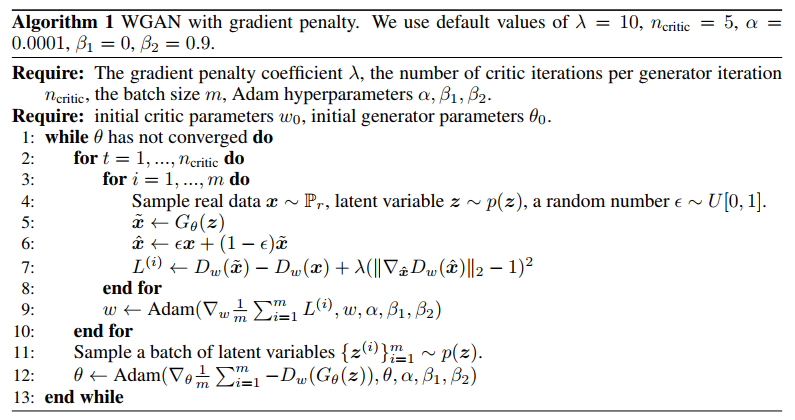

In [17]:
torch.tensor(0.)

tensor(0.)

In [18]:
torch.tensor([0.])

tensor([0.])

In [28]:
class GAN(GANBase):
    def __init__(self, n_filters, lam=10):
        super().__init__()
        self.lam = lam
        self.noise = Normal(loc=torch.tensor(0.).to(device), 
                            scale=torch.tensor(1.0).to(device))
        self.generator = Generator(n_filters)
        self.discriminator = Discriminator(n_filters)
        self.uniform = Uniform(torch.tensor(0.).to(device), 
                               torch.tensor(1.).to(device))
    def generate(self, N):
        noise = self.noise.sample(sample_shape=(N, 128))
        return self.generator(noise)
    
    def generator_loss(self, minibatch_size):
        z = self.generate(minibatch_size)
        return -self.discriminator(z).mean(axis=0)
    
    def discriminator_loss(self, x):
        z = self.generate(len(x))
        eps = self.uniform.sample((len(x), 1, 1, 1))
        x_hat = eps * x.data + (1 - eps) * z.data
        x_hat.requires_grad = True
        loss = (self.discriminator(z) - self.discriminator(x)).mean(axis=0)
        D_x_hat = self.discriminator(x_hat)
        gradients = torch.autograd.grad(outputs=D_x_hat, inputs=x_hat,
                                        grad_outputs=torch.ones(
                                            D_x_hat.size()).to(device),
                                        create_graph=True, retain_graph=True)[0]
        gradients = gradients.reshape(len(x), -1)
        loss += self.lam * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return loss

In [41]:
def q2(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """
    print(f'min: {np.min(train_data)}')
    print(f'max: {np.max(train_data)}')
    dataloader = data.DataLoader(train_data[:256], batch_size=256, shuffle=True)
    #n_epoch = 25000 // len(dataloader) + 1
    n_epochs=1
    print(f"n_epochs = {n_epochs}")

    model = GAN(128).to(device)
    generator_opt = torch.optim.Adam(model.generator.parameters(), lr=2e-4, 
                                     betas=(0, 0.9))
    discriminator_opt = torch.optim.Adam(model.discriminator.parameters(), lr=2e-4, 
                                         betas=(0, 0.9))

    generator_scheduler = torch.optim.lr_scheduler.StepLR(generator_opt, 
                                                    step_size=1, gamma=0.9)
    discriminator_scheduler = torch.optim.lr_scheduler.StepLR(discriminator_opt, 
                                                        step_size=1, gamma=0.9)
    discriminator_losses, generator_losses, _ = train(
        model, generator_opt, discriminator_opt, dataloader, 
        update_generator_every=2, num_epochs=n_epochs, need_additional=False, 
        generator_scheduler=generator_scheduler, 
        discriminator_scheduler=discriminator_scheduler)
    
    model.generator.eval()
    model.generator.mode('eval')

    model.discriminator.eval()
    model.discriminator.mode('eval')
    
    generated = model.generate(1000).cpu().permute(0, 2, 3, 1).numpy()
    return discriminator_losses, np.clip(generated, 0, 1)

## Results

Files already downloaded and verified
min: 0.0
max: 1.0
n_epochs = 1
Epoch: 0, Discriminator loss: 6.642549725679251, Generator loss: -11.565146705515835
..........Inception score: 1.4033155


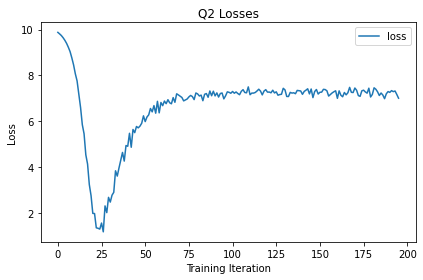

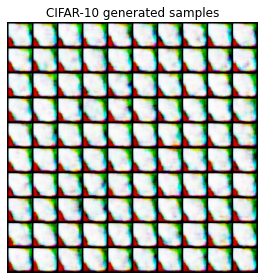

In [42]:
q2_save_results(q2)

# Question 3: Representation Learning with BiGAN on MNIST [45pt]

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done!


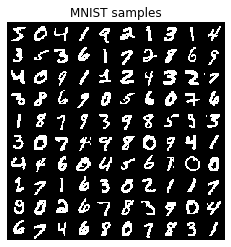

In [ ]:
visualize_q3_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution

In [ ]:
def q3(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """

## Results

In [ ]:
q3_save_results(q3)

# Question 4 (Bonus): CycleGAN [20pt]
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

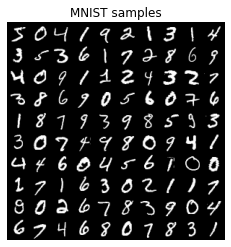

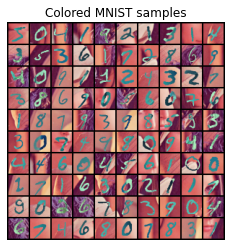

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def q4(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

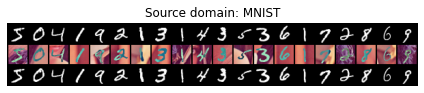

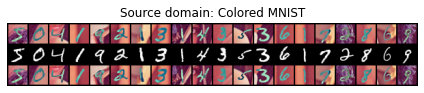

In [ ]:
q4_save_results(q4)